### Autoencoder model on CTG dataset
- Load Data
- Preprocess Data
- Perform PCA on Data
- Define Autoencoder Model
- Train Model
- Generate predictions for Train and Test Sets
- Perform PCA on Encoded Data
- Evaluate generated data on classification models

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
ctg_data = pd.read_csv('../CTGRawData.csv', sep=';')

In [2]:
# Preprocess Data
# Separate Features from labels (last column)
y = ctg_data['NSP']
X = ctg_data.drop('NSP',axis=1).iloc[:,:21]
from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [3]:
# Normalization of data sets
# Data Scaling MinMax
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = X_train
X_test_norm = X_test

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train_norm))
X_test_norm = pd.DataFrame(scaler.transform(X_test_norm))


In [4]:
# Check Shape of data
print(X_train_norm.head())
print(X_train_norm.shape)
print(np.array(X_train_norm)[:5])
# 21 features that we are going to try to reduce.

         0         1         2         3         4         5         6   \
0  0.075472  0.115385  0.000000  0.391304  0.689189  0.088235  0.000000   
1  0.754717  0.000000  0.030142  0.000000  0.810811  0.014706  0.450549   
2  0.320755  0.000000  0.000000  0.000000  0.391892  0.102941  0.252747   
3  0.679245  0.000000  0.000000  0.260870  0.621622  0.029412  0.241758   
4  0.320755  0.000000  0.000000  0.043478  0.648649  0.058824  0.000000   

         7       8    9   ...        11        12        13        14   15  \
0  0.260766  0.0625  0.0  ...  0.344633  0.388889  0.293103  0.166667  0.0   
1  0.165072  0.0000  0.0  ...  0.180791  0.648148  0.284483  0.222222  0.0   
2  0.253589  0.0000  0.0  ...  0.451977  0.083333  0.172414  0.222222  0.0   
3  0.150718  0.0000  0.0  ...  0.056497  0.879630  0.310345  0.000000  0.0   
4  0.248804  0.0000  0.0  ...  0.276836  0.314815  0.120690  0.222222  0.0   

         16        17        18        19   20  
0  0.409449  0.366972  0.330275

_____________________________
### PCA

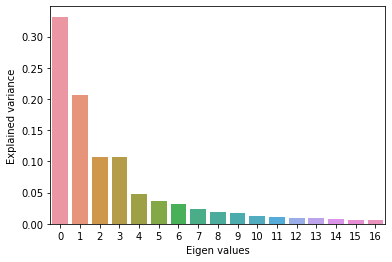

0.9929553479372581

In [20]:
# Perform PCA to find the most significant features
from sklearn.decomposition import PCA
# select the number of components
pca = PCA(n_components = 17)
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

sns.barplot(np.arange(np.shape(pca.explained_variance_ratio_)[0]),pca.explained_variance_ratio_)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")
plt.show()

pca.explained_variance_ratio_.sum()

__________________________________________
### Autoencoder

In [24]:
## Definition of Auxiliar functions: loss function, gradient function and model training function
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import List

def loss(x: np.ndarray, x_bar: np.ndarray) -> float:
    return tf.losses.mean_squared_error(x, x_bar)

def grad(model: keras.models.Model, inputs: np.ndarray):
    with tf.GradientTape() as tape:
        reconstruction, inputs_reshaped = model(inputs)
        loss_value = loss(inputs_reshaped, reconstruction)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), inputs_reshaped, reconstruction

def train_model(model: keras.models.Model, inputs: pd.DataFrame, num_epochs: int, batch_size: int):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    x_train = np.array(inputs)

    for epoch in range(num_epochs):
        print("Epoch: ", epoch)
        for x in range(0, len(x_train), batch_size):
            x_inp = x_train[x : x + batch_size]
            loss_value, grads, inputs_reshaped, reconstruction = grad(model, x_inp)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        print("Step: {},Loss: {}".format(epoch, sum(loss(inputs_reshaped, reconstruction)/batch_size).numpy()))

In [22]:
# Define Autoencoder
class ComposeAutoEncoder(keras.models.Model):
    def __init__(self):
        super(ComposeAutoEncoder, self).__init__()
        
        # this is the size of our encoded representations
        encoding_dim = 16  # 21/16 - we will try to reduce the dimensions to this number.
        # this is our input placeholder
        input_features = layers.Input(shape=(21))

        self.flatten_input = layers.Flatten()(input_features)
        # "Encoder layers"
        self.encoder1 = layers.Dense(64, activation='relu')(self.flatten_input)
        self.encoder2 = layers.Dense(32, activation='relu')(self.encoder1)
        # "Encoder output" - "bottleneck"
        self.bottleneck = layers.Dense(encoding_dim, activation='relu')(self.encoder2)
        # this model maps an input to its encoded representation
        self.encoder = keras.models.Model(input_features, self.bottleneck, name='encoder')

        # "Decoder layers"
        # create a placeholder for an encoded (32-dimensional) input
        self.encoded_input = layers.Input(shape=(encoding_dim,))
        self.decoder1 = layers.Dense(32, activation='relu')(self.encoded_input)
        self.decoder2 = layers.Dense(64, activation='relu')(self.decoder1)
        # "decoded" is the lossy reconstruction of the input
        self.decoded = layers.Dense(21, activation='sigmoid')(self.decoder1)
        # create the decoder model
        self.decoder = keras.models.Model(self.encoded_input, self.decoded, name='decoder')

    
    def call(self, inp):
        # full autoencoder for training
        encoder_model = self.encoder(inp)
        decoder_model = self.decoder(encoder_model)

        return decoder_model, inp

In [25]:
# Instantiate and train model
autoencoder = ComposeAutoEncoder()
train_model(autoencoder, X_train_norm, num_epochs=100, batch_size=400)

Epoch:  0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Step: 0,Loss: 0.029771875590085983
Epoch:  1
Step: 1,Loss: 0.027637716382741928
Epoch:  2
Step: 2,Loss: 0.02528516575694084
Epoch:  3
Step: 3,Loss: 0.022531632333993912
Epoch:  4
Step: 4,Loss: 0.019589239731431007
Epoch:  5
Step: 5,Loss: 0.016744475811719894
Epoch:  6
Step: 6,Loss: 0.014318683184683323
Epoch:  7
Step: 7,Loss: 0.012402805499732494
Epoch:  8
Step: 8,Loss: 0.010904762893915176
Epoch:  9
Step: 9,Loss: 0.009764164686203003
Epoch:  10
Step: 10,Loss: 0.008924370631575584
Epoch:  11
S

In [26]:
predictions = autoencoder.predict(np.array(X_test_norm))

In [27]:
predictions_dataframe = pd.DataFrame(predictions[0])
original_dataframe = pd.DataFrame(predictions[1])
print(predictions_dataframe.iloc[:,:5].describe())
print(original_dataframe.iloc[:,:5].describe())

                0           1           2           3           4
count  426.000000  426.000000  426.000000  426.000000  426.000000
mean     0.538262    0.122737    0.002769    0.163167    0.484781
std      0.162843    0.066525    0.004602    0.087171    0.210095
min      0.189074    0.018304    0.000093    0.036493    0.108384
25%      0.405602    0.069148    0.000600    0.098253    0.283387
50%      0.534478    0.109526    0.001106    0.143765    0.506058
75%      0.677090    0.167591    0.003033    0.210171    0.652719
max      0.886439    0.325407    0.032802    0.540728    0.901449
                0           1           2           3           4
count  426.000000  426.000000  426.000000  426.000000  426.000000
mean     0.530251    0.103467    0.010480    0.148908    0.478810
std      0.184262    0.134833    0.046596    0.120898    0.231382
min      0.075472    0.000000    0.000000    0.000000    0.000000
25%      0.396226    0.000000    0.000000    0.043478    0.270270
50%      0

In [31]:
sum(loss(predictions[1], predictions[0]))/len(predictions[1])

<tf.Tensor: id=130645, shape=(), dtype=float32, numpy=0.0043272427>

In [47]:
## Encode Train and Test Data
encoded_train = autoencoder.encoder.predict(X_train_norm)
encoded_test = autoencoder.encoder.predict(X_test_norm)

# Renormalize input
scaler = MinMaxScaler()
encoded_train = pd.DataFrame(scaler.fit_transform(encoded_train))
encoded_test = pd.DataFrame(scaler.transform(encoded_test))

______________________________________
### PCA on encoded data

In [51]:
pca = PCA(n_components=2)
pca.fit(encoded_train)
encoded_pca_train = pca.transform(encoded_train)
encoded_pca_test = pca.transform(encoded_test)

No handles with labels found to put in legend.


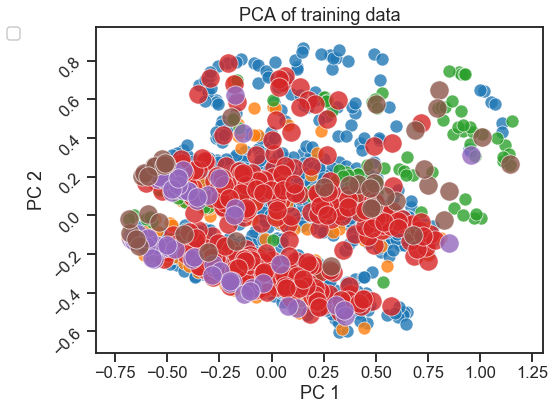

In [60]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot()
sns.scatterplot(x=encoded_pca_train[(y_train == 1).ravel(),0], y=encoded_pca_train[(y_train == 1).ravel(),1], alpha = 0.8, s= 170, legend='full')
sns.scatterplot(x=encoded_pca_train[(y_train == 2).ravel(),0], y=encoded_pca_train[(y_train == 2).ravel(),1], alpha = 0.8, s= 170, legend='full')
sns.scatterplot(x=encoded_pca_train[(y_train == 3).ravel(),0], y=encoded_pca_train[(y_train == 3).ravel(),1], alpha = 0.8, s= 170, legend='full')
sns.scatterplot(x=encoded_pca_test[(y_test == 1).ravel(),0], y=encoded_pca_test[(y_test == 1).ravel(),1], alpha = 0.8, s= 370, legend='full')
sns.scatterplot(x=encoded_pca_test[(y_test == 2).ravel(),0], y=encoded_pca_test[(y_test == 2).ravel(),1], alpha = 0.8, s= 370, legend='full')
sns.scatterplot(x=encoded_pca_test[(y_test == 3).ravel(),0], y=encoded_pca_test[(y_test == 3).ravel(),1], alpha = 0.8, s= 370, legend='full')
ax1.legend(bbox_to_anchor=(-0.2, 1), loc=2, borderaxespad=0.,framealpha=1, frameon=True)
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (8,6) )
ax1.set_title("PCA of training data")
plt.yticks(rotation=45) 
plt.show()

In [ ]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot()
sns.scatterplot(x=encoded_pca_train[(y_train == 1).ravel(),0], y=encoded_pca_train[(y_train == 1).ravel(),1], alpha = 0.8, s= 170, legend='full')
sns.scatterplot(x=encoded_pca_train[(y_train == 2).ravel(),0], y=encoded_pca_train[(y_train == 2).ravel(),1], alpha = 0.8, s= 170, legend='full')
sns.scatterplot(x=encoded_pca_train[(y_train == 3).ravel(),0], y=encoded_pca_train[(y_train == 3).ravel(),1], alpha = 0.8, s= 170, legend='full')
sns.scatterplot(x=encoded_pca_test[(y_test == 1).ravel(),0], y=encoded_pca_test[(y_test == 1).ravel(),1], alpha = 0.8, s= 370, legend='full')
sns.scatterplot(x=encoded_pca_test[(y_test == 2).ravel(),0], y=encoded_pca_test[(y_test == 2).ravel(),1], alpha = 0.8, s= 370, legend='full')
sns.scatterplot(x=encoded_pca_test[(y_test == 3).ravel(),0], y=encoded_pca_test[(y_test == 3).ravel(),1], alpha = 0.8, s= 370, legend='full')
ax1.legend(bbox_to_anchor=(-0.2, 1), loc=2, borderaxespad=0.,framealpha=1, frameon=True)
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (8,6) )
ax1.set_title("PCA of training data")
plt.yticks(rotation=45) 
plt.show()

In [56]:
(y_train == 2).ravel()

array([False,  True, False, ..., False, False, False])

______________________
### DNN Classifier

In [34]:


# One hot encode labels
from sklearn.preprocessing import LabelEncoder
OH_encoder = LabelEncoder()
OH_y_train = pd.DataFrame(OH_encoder.fit_transform(y_train))
OH_y_test = pd.DataFrame(OH_encoder.transform(y_test))
y_train_oh = keras.utils.to_categorical(OH_y_train)
y_test_oh = keras.utils.to_categorical(OH_y_test)

In [43]:
## Test the encoded input on the best classifier obtained previously (CTG_dataset_classification)
def build_best_model(penalization: int, input_shape):
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization), input_shape=(input_shape,)),
    layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(64,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(3,activation=tf.nn.softmax)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

In [45]:
# Fit best model with original dimension data
best_model = build_best_model(0.00001, len(X_train_norm.keys()))
history = best_model.fit(X_train_norm, y_train_oh, epochs=86,
                    validation_split = 0, verbose=0, callbacks=[])
hist = pd.DataFrame(history.history)

test_loss, test_acc = best_model.evaluate(X_test_norm, y_test_oh)

# Fit best model with reduced dimension data
encoded_model = build_best_model(0.00001, len(encoded_train.keys()))
history_encoded = encoded_model.fit(encoded_train, y_train_oh, epochs=86,
                    validation_split = 0, verbose=0, callbacks=[])
hist_encoded = pd.DataFrame(history_encoded.history)

test_loss, test_acc = encoded_model.evaluate(encoded_test, y_test_oh)

426/426 [==============================] - 0s 178us/sample - loss: 0.3244 - accuracy: 0.8826


### Differences:
##### 1- original data=0.9202 ; reduced data= 0.9131
##### 2- original data=0.9296 ; reduced data= 0.8991
##### 3- original data=0.9131 ; reduced data= 0.8826